# Data & Imports

In [1]:
import autokeras as ak
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# constants
path = 'C:/Users/Asus/Documents/2023_2/Memoria/src'

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines_trim.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines_trim.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_trim_v2.csv')

Using TensorFlow backend


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
X_obs = Obs_df.drop(target+['HD','date','time'],axis=1)
Y_obs = Obs_df[target]

X = np.random.normal(loc=0, scale=0.02, size=X.shape) + X
y_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=42)

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

formatted_x_train = np.expand_dims(x_train, axis=2) #This step it's very important an CNN will only accept this data shape
formatted_x_val = np.expand_dims(x_val, axis=2)
formatted_x_test = np.expand_dims(x_test, axis=2)
formatted_x_obs = np.expand_dims(X_obs, axis=2)


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [3]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# AutoModel

In [4]:
from keras_tuner.engine import hyperparameters as hp

# convBlock
conv_kernel_size = hp.Choice("kernel_size", [3,5,7],)
conv_num_layers = hp.Choice("conv_layers", [2,3],)
conv_num_blocks = hp.Choice("conv_blocks", [2,3],)
conv_filters = hp.Choice("filters", [32,64,128,256],)

# # DenseBlock
dense_num_layers = hp.Choice("dense_layers", [1,2,3])
dense_units = hp.Choice("dense_units", [32,64,128,256,512])

# RegressionHead
# head_dropout = hp.Float(
#                 'dropout_head',
#                 min_value=0.0,
#                 max_value=0.5,
#                 default=0.25,
#                 step=0.05,
#             )

input = ak.Input()
conv = ak.ConvBlock(
  	kernel_size=conv_kernel_size,
  	num_blocks=conv_num_blocks,
  	num_layers=conv_num_layers,
  	filters=conv_filters,
  	max_pooling=True,
		separable=False,
  	#dropout=conv_dropout,
)(input)
dense = ak.DenseBlock(
  	num_layers=dense_num_layers, 
  	num_units=dense_units, 
  	use_batchnorm=False, 
  	#dropout=dense_dropout
)(conv)
regression_output = ak.RegressionHead(
  	output_dim=3, 
   	loss="mse", 
    metrics=["mae"], 
    #dropout=head_dropout,
)(dense)


def generateAutoModel():
  return ak.AutoModel(
	inputs=input,
	outputs=regression_output,
	max_trials=100,
	loss='mse',
	metrics = 'mae',
	tuner='greedy',
	overwrite=False,
	seed=19,
	max_model_size=None,)

model = generateAutoModel()


Reloading Tuner from .\auto_model\tuner0.json


In [5]:
model.fit(formatted_x_train, y_train,validation_data=(formatted_x_val, y_val), epochs=50)


Epoch 1/50
459/459 [==============================] - 15s 11ms/step - loss: 0.1045 - mae: 0.2598 - val_loss: 0.0587 - val_mae: 0.1792
Epoch 2/50
459/459 [==============================] - 5s 10ms/step - loss: 0.0324 - mae: 0.1305 - val_loss: 0.0282 - val_mae: 0.1212
Epoch 3/50
459/459 [==============================] - 5s 10ms/step - loss: 0.0234 - mae: 0.1084 - val_loss: 0.0214 - val_mae: 0.1016
Epoch 4/50
459/459 [==============================] - 5s 10ms/step - loss: 0.0201 - mae: 0.0996 - val_loss: 0.0195 - val_mae: 0.0958
Epoch 5/50
459/459 [==============================] - 5s 10ms/step - loss: 0.0188 - mae: 0.0956 - val_loss: 0.0175 - val_mae: 0.0868
Epoch 6/50
459/459 [==============================] - 5s 11ms/step - loss: 0.0171 - mae: 0.0902 - val_loss: 0.0174 - val_mae: 0.0931
Epoch 7/50
459/459 [==============================] - 5s 10ms/step - loss: 0.0165 - mae: 0.0878 - val_loss: 0.0148 - val_mae: 0.0813
Epoch 8/50
459/459 [==============================] - 5s 10ms/step -

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [6]:
exp = model.export_model()
exp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 139, 1)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 139, 1)           0         
 t32)                                                            
                                                                 
 conv1d (Conv1D)             (None, 137, 256)          1024      
                                                                 
 conv1d_1 (Conv1D)           (None, 135, 256)          196864    
                                                                 
 conv1d_2 (Conv1D)           (None, 133, 128)          98432     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 66, 128)          0         
 )                                                           

In [7]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(formatted_x_test, y_test)

print('loss: %.3f  MAE:%.3f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 1s 6ms/step - loss: 0.0115 - mae: 0.0632
loss: 0.012  MAE:0.063


In [8]:
predictions = y_scaler.inverse_transform(model.predict(formatted_x_test))

153/153 [==============================] - 1s 3ms/step


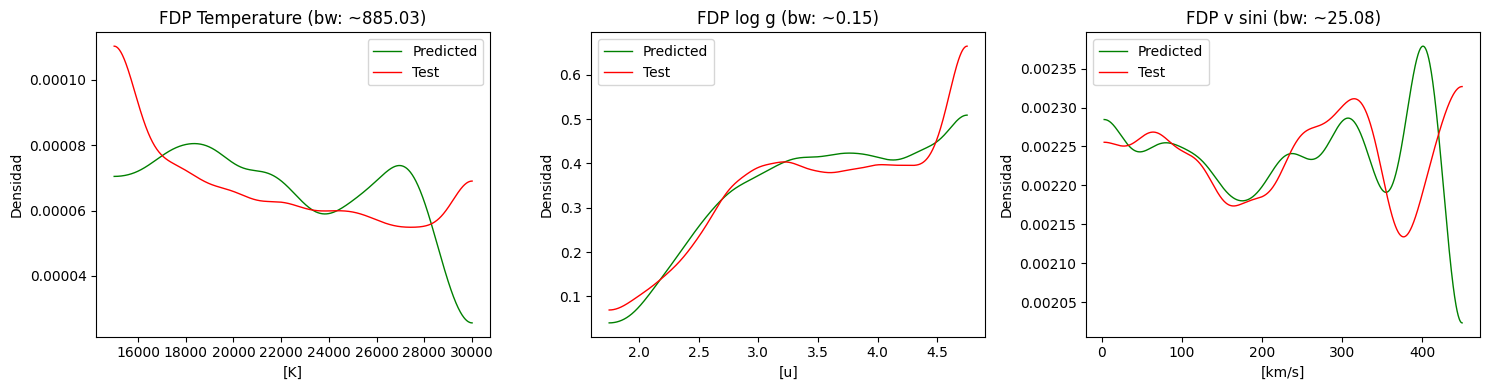

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Predicted')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Densidad')
	axes[i].set_title('FDP '+measure[i]+' (bw: ~%.2f'%(kde.bandwidth_)+')')
	axes[i].legend()

plt.legend()
plt.tight_layout();
plt.show()

In [10]:
np.mean(np.abs(y_scaler.transform(predictions)-y_test),axis=0)

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([0.11306806, 0.0561882 , 0.02046959])

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


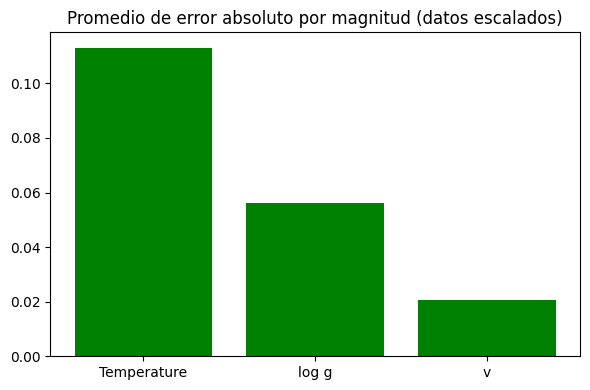

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(y_scaler.transform(predictions)-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


### Datos de test vs predicción (modelo único)

In [12]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
pred_error = np.abs(predictions-inverse_y_test)*(1/inverse_y_test)*100
results = pd.DataFrame({
  'Temp':inverse_y_test[:,0],'Temp_pred':predictions[:,0],'Temp_Rel_Error':pred_error[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':predictions[:,1],'log_g_Rel_Error':pred_error[:,1],
  'v':inverse_y_test[:,2],'v_pred':predictions[:,2],'v_Rel_Error':pred_error[:,2]
                    })
results.head(10)

,Temp,Temp_pred,Temp_Rel_Error,log_g,log_g_pred,log_g_Rel_Error,v,v_pred,v_Rel_Error
0,28000.0,30410.806641,8.610024,2.75,2.825673,2.751749,156.0,179.002670,14.745301
1,27000.0,27798.521484,2.957487,4.25,4.296613,1.096770,24.0,21.963232,8.486533
2,28000.0,27599.884766,1.428983,4.50,4.540243,0.894292,213.0,222.184601,4.312019
3,28000.0,28677.044922,2.418018,4.50,4.490757,0.205400,36.0,38.606251,7.239585
4,16000.0,14914.284180,6.785724,2.50,2.671013,6.840534,327.0,324.382965,0.800316
5,18000.0,17515.486328,2.691743,3.25,3.363969,3.506748,216.0,213.269669,1.264042
6,22000.0,20794.341797,5.480265,3.50,3.430624,1.982171,54.0,52.181877,3.366894
7,21000.0,15615.679688,25.639621,3.25,3.663013,12.708106,321.0,320.380249,0.193069
8,18000.0,18393.294922,2.184972,3.75,3.707874,1.123365,72.0,71.988701,0.015693
9,20000.0,19890.007812,0.549961,4.00,3.992286,0.192845,138.0,130.420837,5.492147


### Datos observados vs predicción de modelo único

In [13]:
predictions = y_scaler.inverse_transform(model.predict(formatted_x_obs))

inverse_y_obs = y_scaler.inverse_transform(y_obs)
pred_error = np.abs(predictions-inverse_y_obs)*(1/inverse_y_obs)*100
results = pd.DataFrame({
  'Temp':inverse_y_obs[:,0],'Temp_pred':predictions[:,0],'Temp_Rel_Error':pred_error[:,0],
  'log_g':inverse_y_obs[:,1],'log_g_pred':predictions[:,1],'log_g_Rel_Error':pred_error[:,1],
  'v':inverse_y_obs[:,2],'v_pred':predictions[:,2],'v_Rel_Error':pred_error[:,2]
                    })
results.head(10)



3/3 [==============================] - 0s 4ms/step


,Temp,Temp_pred,Temp_Rel_Error,log_g,log_g_pred,log_g_Rel_Error,v,v_pred,v_Rel_Error
0,19526.0,16850.201172,13.703774,3.3,3.364841,1.964893,287.0,278.439728,2.982673
1,19526.0,15316.811523,21.556839,3.3,3.849142,16.640676,287.0,290.342346,1.164581
2,19526.0,18692.042969,4.271008,3.3,3.029260,8.204230,287.0,291.721161,1.645004
3,19526.0,17672.121094,9.494412,3.3,3.161806,4.187694,287.0,260.434692,9.256205
4,19526.0,18212.863281,6.725068,3.3,3.257479,1.288509,287.0,293.546204,2.280907
5,17000.0,19842.931641,16.723127,4.0,3.500914,12.477148,240.0,265.385376,10.577240
6,17000.0,17692.335938,4.072564,4.0,3.907131,2.321732,240.0,260.165619,8.402341
7,17000.0,18575.648438,9.268520,4.0,3.340631,16.484213,240.0,267.177856,11.324107
8,17000.0,23461.816406,38.010685,4.0,3.279664,18.008393,240.0,288.723541,20.301476
9,17000.0,29402.021484,72.953068,4.0,3.267531,18.311733,240.0,275.456085,14.773369


# Ensemble

In [16]:
from scipy.sparse import coo_matrix
from sklearn.utils import resample

NUM_MODELS = 30
models = []
history = []

x_train_sparse = coo_matrix(x_train)

for i in range(NUM_MODELS):
	am = generateAutoModel()
	x_train_resampled, x_train_sparse, y_train_resampled = resample(x_train, x_train_sparse, y_train, random_state=i)
	x_train_resampled = np.expand_dims(x_train_resampled, axis=2)
	history.append(am.fit(x=x_train_resampled, y=y_train_resampled, epochs=30))
	models.append(am.export_model())

Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0962 - mae: 0.2483
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0287 - mae: 0.1234
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0220 - mae: 0.1053
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0183 - mae: 0.0933
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0175 - mae: 0.0914
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0158 - mae: 0.0855
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0155 - mae: 0.0848
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0146 - mae: 0.0810
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0140 - mae: 0.0794
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0135 - mae: 0.0771
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0990 - mae: 0.2513
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0311 - mae: 0.1278
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0212 - mae: 0.1029
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0181 - mae: 0.0928
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0164 - mae: 0.0879
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0155 - mae: 0.0847
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0150 - mae: 0.0831
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0142 - mae: 0.0806
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0141 - mae: 0.0801
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0135 - mae: 0.0777
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 8s 10ms/step - loss: 0.0944 - mae: 0.2428
Epoch 2/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0255 - mae: 0.1153
Epoch 3/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0214 - mae: 0.1046
Epoch 4/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0179 - mae: 0.0930
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0166 - mae: 0.0888
Epoch 6/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0153 - mae: 0.0846
Epoch 7/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0144 - mae: 0.0809
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0142 - mae: 0.0801
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0138 - mae: 0.0790
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0136 - mae: 0.07

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0910 - mae: 0.2390
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0303 - mae: 0.1269
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0215 - mae: 0.1037
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0190 - mae: 0.0963
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0172 - mae: 0.0907
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0159 - mae: 0.0857
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0153 - mae: 0.0839
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0150 - mae: 0.0824
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0141 - mae: 0.0794
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0139 - mae: 0.0790
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0922 - mae: 0.2433
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0297 - mae: 0.1246
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0209 - mae: 0.1017
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0180 - mae: 0.0927
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0170 - mae: 0.0898
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0158 - mae: 0.0857
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0144 - mae: 0.0812
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0140 - mae: 0.0798
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0137 - mae: 0.0784
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0131 - mae: 0.0763
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0981 - mae: 0.2521
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0309 - mae: 0.1286
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0204 - mae: 0.1006
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0187 - mae: 0.0954
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0165 - mae: 0.0878
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0156 - mae: 0.0848
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0145 - mae: 0.0811
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0142 - mae: 0.0805
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0135 - mae: 0.0779
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0135 - mae: 0.0773
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0968 - mae: 0.2480
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0275 - mae: 0.1193
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0213 - mae: 0.1027
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0184 - mae: 0.0945
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0162 - mae: 0.0872
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0153 - mae: 0.0840
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0147 - mae: 0.0825
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0144 - mae: 0.0813
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0137 - mae: 0.0785
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0131 - mae: 0.0764
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0948 - mae: 0.2478
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0283 - mae: 0.1207
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0217 - mae: 0.1040
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0188 - mae: 0.0952
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0174 - mae: 0.0906
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0161 - mae: 0.0873
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0144 - mae: 0.0804
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0144 - mae: 0.0805
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0138 - mae: 0.0786
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0136 - mae: 0.0776
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0977 - mae: 0.2519
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0401 - mae: 0.1495
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0216 - mae: 0.1036
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0187 - mae: 0.0949
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0167 - mae: 0.0887
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0158 - mae: 0.0858
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0148 - mae: 0.0825
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0144 - mae: 0.0807
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0142 - mae: 0.0799
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0132 - mae: 0.0765
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0946 - mae: 0.2460
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0345 - mae: 0.1354
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0215 - mae: 0.1027
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0183 - mae: 0.0934
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0165 - mae: 0.0874
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0155 - mae: 0.0847
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0157 - mae: 0.0853
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0144 - mae: 0.0815
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0137 - mae: 0.0791
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0137 - mae: 0.0788
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0958 - mae: 0.2482
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0491 - mae: 0.1688
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0260 - mae: 0.1145
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0198 - mae: 0.0980
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0177 - mae: 0.0922
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0159 - mae: 0.0862
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0157 - mae: 0.0856
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0147 - mae: 0.0820
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0142 - mae: 0.0801
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0137 - mae: 0.0783
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0959 - mae: 0.2476
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0294 - mae: 0.1234
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0208 - mae: 0.1018
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0187 - mae: 0.0958
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0173 - mae: 0.0909
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0162 - mae: 0.0871
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0150 - mae: 0.0828
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0146 - mae: 0.0811
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0139 - mae: 0.0790
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0131 - mae: 0.0763
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0911 - mae: 0.2417
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0285 - mae: 0.1229
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0215 - mae: 0.1031
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0184 - mae: 0.0935
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0171 - mae: 0.0902
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0158 - mae: 0.0853
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0149 - mae: 0.0822
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0147 - mae: 0.0819
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0141 - mae: 0.0797
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0134 - mae: 0.0770
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0984 - mae: 0.2527
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0309 - mae: 0.1278
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0222 - mae: 0.1064
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0186 - mae: 0.0956
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0166 - mae: 0.0889
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0157 - mae: 0.0856
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0149 - mae: 0.0830
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0146 - mae: 0.0819
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0136 - mae: 0.0778
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0132 - mae: 0.0763
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0964 - mae: 0.2475
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0345 - mae: 0.1364
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0221 - mae: 0.1050
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0196 - mae: 0.0979
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0171 - mae: 0.0900
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0159 - mae: 0.0861
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0151 - mae: 0.0836
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0142 - mae: 0.0803
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0136 - mae: 0.0780
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0136 - mae: 0.0786
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0959 - mae: 0.2484
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0320 - mae: 0.1296
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0206 - mae: 0.1011
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0177 - mae: 0.0919
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0161 - mae: 0.0866
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0157 - mae: 0.0854
Epoch 7/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0151 - mae: 0.0832
Epoch 8/30
459/459 [==============================] - 4s 10ms/step - loss: 0.0145 - mae: 0.0808
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0139 - mae: 0.0786
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0134 - mae: 0.0769


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0934 - mae: 0.2442
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0287 - mae: 0.1217
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0216 - mae: 0.1034
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0185 - mae: 0.0945
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0171 - mae: 0.0895
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0161 - mae: 0.0861
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0154 - mae: 0.0836
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0148 - mae: 0.0817
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0137 - mae: 0.0778
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0135 - mae: 0.0776
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0981 - mae: 0.2522
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0364 - mae: 0.1406
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0214 - mae: 0.1024
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0184 - mae: 0.0944
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0174 - mae: 0.0909
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0158 - mae: 0.0859
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0148 - mae: 0.0824
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0141 - mae: 0.0797
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0139 - mae: 0.0787
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0127 - mae: 0.0740
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 6s 9ms/step - loss: 0.0976 - mae: 0.2477
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0339 - mae: 0.1359
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0219 - mae: 0.1048
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0184 - mae: 0.0941
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0170 - mae: 0.0894
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0155 - mae: 0.0848
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0145 - mae: 0.0815
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0144 - mae: 0.0810
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0141 - mae: 0.0800
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0133 - mae: 0.0771
Epo

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 6s 10ms/step - loss: 0.0943 - mae: 0.2469
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0298 - mae: 0.1247
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0221 - mae: 0.1058
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0180 - mae: 0.0933
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0166 - mae: 0.0886
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0155 - mae: 0.0847
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0148 - mae: 0.0819
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0143 - mae: 0.0801
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0136 - mae: 0.0780
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0134 - mae: 0.0771
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0942 - mae: 0.2474
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0290 - mae: 0.1239
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0214 - mae: 0.1043
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0186 - mae: 0.0949
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0173 - mae: 0.0908
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0160 - mae: 0.0859
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0150 - mae: 0.0831
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0148 - mae: 0.0822
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0137 - mae: 0.0779
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0137 - mae: 0.0775
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 6s 9ms/step - loss: 0.0958 - mae: 0.2503
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0307 - mae: 0.1272
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0216 - mae: 0.1042
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0187 - mae: 0.0949
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0172 - mae: 0.0906
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0160 - mae: 0.0868
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0149 - mae: 0.0826
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0143 - mae: 0.0803
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0136 - mae: 0.0779
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0131 - mae: 0.0759
Epo

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0915 - mae: 0.2415
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0257 - mae: 0.1152
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0213 - mae: 0.1036
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0172 - mae: 0.0899
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0164 - mae: 0.0879
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0154 - mae: 0.0843
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0143 - mae: 0.0804
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0145 - mae: 0.0816
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0136 - mae: 0.0784
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0138 - mae: 0.0787
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 6s 10ms/step - loss: 0.0969 - mae: 0.2531
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0341 - mae: 0.1351
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0214 - mae: 0.1035
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0184 - mae: 0.0945
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0166 - mae: 0.0882
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0151 - mae: 0.0832
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0149 - mae: 0.0825
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0148 - mae: 0.0822
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0137 - mae: 0.0786
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0134 - mae: 0.0771
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0913 - mae: 0.2416
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0314 - mae: 0.1296
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0204 - mae: 0.0998
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0174 - mae: 0.0914
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0169 - mae: 0.0895
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0155 - mae: 0.0843
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0149 - mae: 0.0823
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0141 - mae: 0.0799
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0143 - mae: 0.0807
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0129 - mae: 0.0754
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0970 - mae: 0.2493
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0321 - mae: 0.1305
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0213 - mae: 0.1028
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0191 - mae: 0.0956
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0168 - mae: 0.0886
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0163 - mae: 0.0875
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0150 - mae: 0.0830
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0137 - mae: 0.0785
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0132 - mae: 0.0771
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0127 - mae: 0.0752
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0931 - mae: 0.2434
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0273 - mae: 0.1195
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0207 - mae: 0.1018
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0186 - mae: 0.0950
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0164 - mae: 0.0876
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0155 - mae: 0.0848
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0149 - mae: 0.0827
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0146 - mae: 0.0815
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0142 - mae: 0.0798
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0142 - mae: 0.0802
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0938 - mae: 0.2453
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0308 - mae: 0.1276
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0219 - mae: 0.1045
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0186 - mae: 0.0945
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0168 - mae: 0.0891
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0155 - mae: 0.0844
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0150 - mae: 0.0823
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0143 - mae: 0.0795
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0135 - mae: 0.0771
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0129 - mae: 0.0745
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 6s 9ms/step - loss: 0.0952 - mae: 0.2470
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0322 - mae: 0.1315
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0225 - mae: 0.1061
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0185 - mae: 0.0938
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0171 - mae: 0.0895
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0162 - mae: 0.0865
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0149 - mae: 0.0819
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0144 - mae: 0.0806
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0139 - mae: 0.0784
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0134 - mae: 0.0766
Epo

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 7s 10ms/step - loss: 0.0968 - mae: 0.2474
Epoch 2/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0276 - mae: 0.1196
Epoch 3/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0212 - mae: 0.1032
Epoch 4/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0183 - mae: 0.0938
Epoch 5/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0160 - mae: 0.0859
Epoch 6/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0149 - mae: 0.0824
Epoch 7/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0148 - mae: 0.0823
Epoch 8/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0140 - mae: 0.0794
Epoch 9/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0133 - mae: 0.0770
Epoch 10/30
459/459 [==============================] - 4s 9ms/step - loss: 0.0135 - mae: 0.0773
Ep

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [17]:
# prediccion de datos observados
predictions = np.array([y_scaler.inverse_transform(model.predict(formatted_x_test)) for model in models]) # dim(predictions) = (num_models, num_rows, num_outputs)

  1/153 [..............................] - ETA: 14s

153/153 [==============================] - 1s 3ms/step


In [18]:
# prediccion del ensamble e incerteza
weights = [model.evaluate(formatted_x_test, y_test)[0] for model in models]
weights = [weight/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)


153/153 [==============================] - 1s 4ms/step - loss: 0.0117 - mae: 0.0649


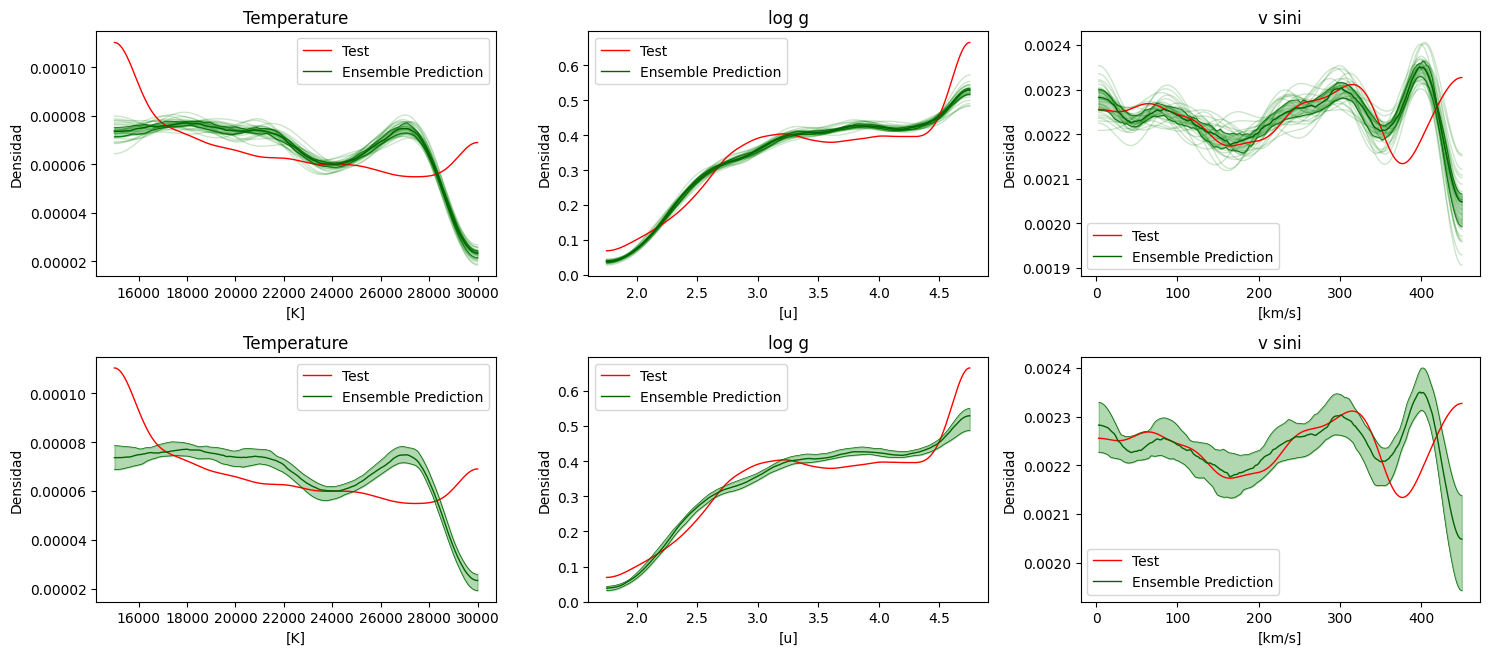

In [19]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st
from scipy.interpolate import interp1d

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6.66))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 2**12)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = predictions[j,:,i] # your data goes here
		x,y,prediction_kde = SKL_density_plot(prediction_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',alpha=0.2)
		f = interp1d(x, y, kind="linear", assume_sorted=True)
		h = f(x_space)*3
		heights.append(h)
  
	heights = np.array(heights)
 
	rescaled_y = y_scaler.inverse_transform(y_test)[:,i]
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[1,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	f = interp1d(x, y, kind="linear", assume_sorted=True)
	test_h = f(x_space)
 
	# cuantiles 50% de los datos
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	axes[0,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.30, color='green')
	
	# cuantiles 95% de los datos
	q5 = np.quantile(heights,0.05,axis=0)
	q95 = np.quantile(heights,0.95,axis=0)
	axes[1,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[1,i].plot(x_space, q5,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, q95,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, q5,q95, alpha=0.30, color='green')
	
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Densidad')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Densidad')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])


plt.tight_layout()
plt.show()

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.w

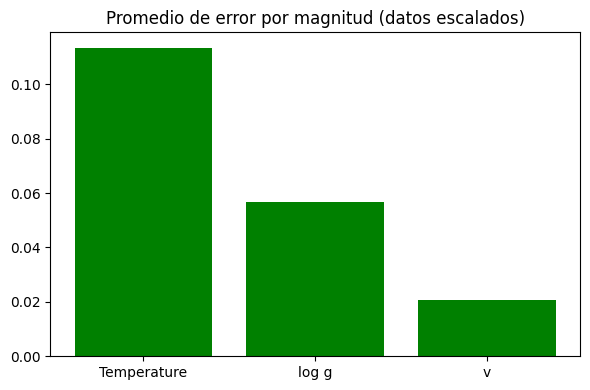

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
x_data = ['Temperature','log g','v']

diff = np.mean(np.array([np.abs(y_scaler.transform(y_hat)-y_test) for y_hat in predictions]),axis=(0,1))
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


### Datos de test vs predicción (ensamble)

In [21]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({
  'Temp':inverse_y_test[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_test[:,2],'v_pred':ensemble_prediction[:,2],'v_Variance':uncertainty[:,2]
                    })
results.head(10)

,Temp,Temp_pred,Temp_Variance,log_g,log_g_pred,log_g_Variance,v,v_pred,v_Variance
0,28000.0,28485.054688,2169.765137,2.75,2.792728,0.164380,156.0,167.557358,8.261031
1,27000.0,27647.076172,435.307220,4.25,4.289520,0.055252,24.0,21.187408,3.276667
2,28000.0,27991.763672,561.015869,4.50,4.515707,0.047514,213.0,216.888901,4.652858
3,28000.0,28269.048828,434.749725,4.50,4.486795,0.043810,36.0,37.973232,4.055771
4,16000.0,15913.677734,807.777832,2.50,2.603351,0.131160,327.0,317.964417,7.887075
5,18000.0,16805.296875,394.018280,3.25,3.577584,0.146261,216.0,202.881561,6.883023
6,22000.0,21369.759766,537.097839,3.50,3.508725,0.045931,54.0,51.426693,3.967447
7,21000.0,15929.631836,485.181274,3.25,3.607880,0.182684,321.0,318.060211,5.500718
8,18000.0,18381.484375,244.544220,3.75,3.714722,0.050003,72.0,72.963554,3.545982
9,20000.0,19846.505859,241.835480,4.00,3.993653,0.044240,138.0,134.226868,4.739301


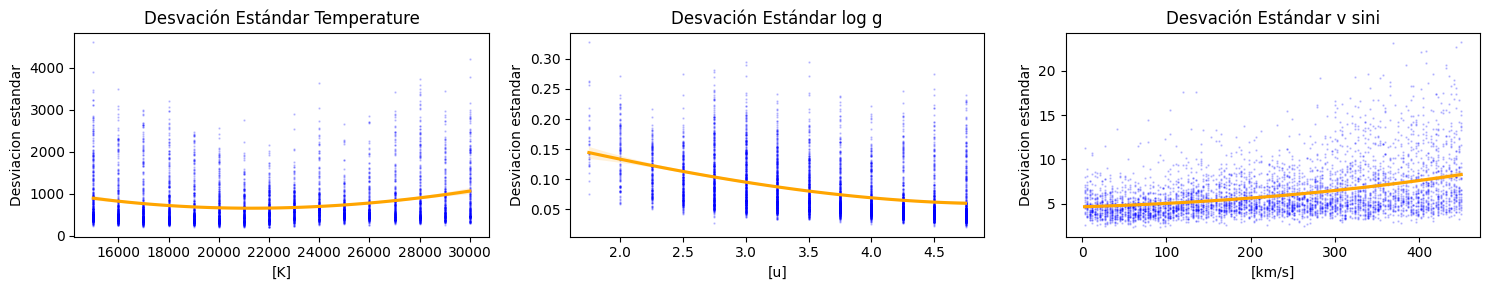

In [22]:
# TODO: algo que permita ver el tamano de las varianzas sobre target feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
feat=['Temp', 'log_g',	'v']
vari=['Temp_Variance','log_g_Variance','v_Variance']
measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[u]', '[km/s]']

for i, featureName in enumerate(target):
	x_data = y_scaler.inverse_transform(y_test)[:,i]
	y_data = uncertainty[:,i]
	sns.regplot(x=feat[i], y=vari[i], data=results,ax=axes[i],scatter_kws=dict(alpha=0.2,color='blue',s=0.5),line_kws=dict(color='orange'), order=3);
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel("Desviacion estandar")
	axes[i].set_title('Desvación Estándar '+measure[i])
	#axes[i].legend()
  
plt.tight_layout()
plt.show()

### Datos observados vs predicción (ensamble)

In [23]:
# generar predicciones e incerteza de ensamble
predictions = np.array([y_scaler.inverse_transform(model.predict(formatted_x_obs)) for model in models])
ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)

3/3 [==============================] - 0s 11ms/step


In [24]:
results.shape

(4890, 9)

In [25]:
# dataframe comparativo de datos observados
inverse_y_obs = y_scaler.inverse_transform(y_obs)
results = pd.DataFrame({
  'Temp':inverse_y_obs[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_obs[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_obs[:,2],'v_pred':ensemble_prediction[:,2],'v_Rel_Variance':uncertainty[:,2]
                    }).join(Obs_df.HD).set_index('HD')
results.head(60)

,Temp,Temp_pred,Temp_Variance,log_g,log_g_pred,log_g_Variance,v,v_pred,v_Rel_Variance
HD,,,,,,,,,
33328,19526.0,16999.359375,414.025848,3.30,3.321969,0.081749,287.0,287.705688,5.708982
33328,19526.0,15666.774414,437.954193,3.30,3.645313,0.146534,287.0,286.868591,7.139709
33328,19526.0,19320.533203,597.276489,3.30,3.132086,0.063538,287.0,296.682007,6.170316
33328,19526.0,16907.792969,1001.373901,3.30,3.621936,0.220388,287.0,273.821228,17.657927
33328,19526.0,17561.798828,682.692322,3.30,3.477026,0.127055,287.0,296.902985,9.148249
35165,17000.0,18309.070312,1364.322388,4.00,3.575915,0.168458,240.0,295.150940,17.777590
35165,17000.0,17505.585938,1043.524902,4.00,3.894672,0.152033,240.0,295.916260,16.760530
35165,17000.0,17113.761719,890.208008,4.00,3.637282,0.184585,240.0,290.310638,12.697462
35165,17000.0,24558.578125,1134.893433,4.00,3.542860,0.124731,240.0,294.196625,11.302714


In [26]:
# / TODO revisar drive con datos de estrellas pucheros
# TODO hacer tabla comparativa con valores predichos y comparar con tabla del paper
# / TODO revisar parametros para probar con autokeras
# / TODO corregir graficos, intervalo de confianza(25%) + distribuciones puntuales, intervalo de confianza 95% sin distribuciones puntuales
# / TODO scatter de valor observado/testing vs prediccion 3 graficos
# / TODO corregir en vez de varianza, std dev
# / TODO grafica comparativa de error con valores escalados 